In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, basename
from uavsar_pytools.convert.tiff_conversion import read_annotation
from copy import deepcopy

from polsar_functions import uavsar_H_A_alpha

In [2]:
x_min, x_max = 3000,3200
y_min, y_max = 10000,10200
def get_polsar_stack(in_dir):
    ann_fp = glob(join(in_dir, '*.ann'))[0]
    desc = read_annotation(ann_fp)
    nrows = desc['grd_pwr.set_rows']['value']
    ncols = desc['grd_pwr.set_cols']['value']
    fps = glob(join(in_dir, '*.grd'))
    pol = {}
    for f in fps:
        name = basename(f).split('_')[-3][4:]
        if name == 'HVVV' or name == 'HHHV' or name == 'HHVV':
            arr = np.fromfile(f, dtype = np.complex64).reshape(nrows, ncols)
        else:
            arr = np.fromfile(f, dtype = np.float32).reshape(nrows, ncols)
        arr[arr == 0] = np.nan
        pol[name] = arr[x_min:x_max,y_min:y_max]
    sub_stack = np.dstack([pol['HHHH'], pol['HHHV'], pol['HVHV'], pol['HVVV'], pol['HHVV'], pol['VVVV']])
    return sub_stack

In [3]:
in_dir = '/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_grd'

In [4]:
stack = get_polsar_stack(in_dir)

In [5]:
H,A,alpha1, mean_alpha = uavsar_H_A_alpha(stack, parralel = True)

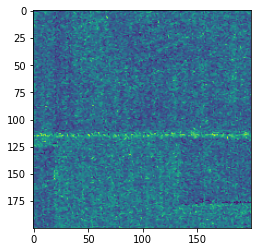

In [6]:
plt.imshow(H)

In [7]:
ann_fp = glob(join(in_dir, '*.ann'))[0]
desc = read_annotation(ann_fp)

In [9]:
import dask.array as da 
nrows = desc['grd_pwr.set_rows']['value']
ncols = desc['grd_pwr.set_cols']['value']
fps = glob(join(in_dir, '*.grd'))
pol = {}
for f in fps:
    name = basename(f).split('_')[-3][4:]
    if name == 'HVVV' or name == 'HHHV' or name == 'HHVV':
        arr = np.fromfile(f, dtype = np.complex64).reshape(nrows, ncols)
    else:
        arr = np.fromfile(f, dtype = np.float32).reshape(nrows, ncols)
    arr[arr == 0] = np.nan
    pol[name] = da.from_array(arr)

In [11]:
da.stack(pol.values(), axis = 2)

dask.array<stack, shape=(14869, 15571, 6), dtype=complex64, chunksize=(4096, 4096, 1), chunktype=numpy.ndarray>

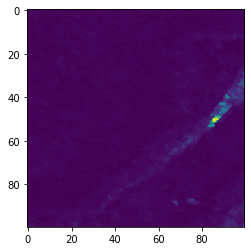

In [5]:
x_min, x_max = 4200,4300
y_min, y_max = 7750,7850
sub_VVVV = pol['VVVV'][x_min:x_max,y_min:y_max]
sub_HHHH = pol['HHHH'][x_min:x_max,y_min:y_max]
sub_HHVV = pol['HHVV'][x_min:x_max,y_min:y_max]
sub_HVHV = pol['HVHV'][x_min:x_max,y_min:y_max]
sub_HVVV = pol['HVVV'][x_min:x_max,y_min:y_max]
sub_HHHV = pol['HHHV'][x_min:x_max,y_min:y_max]

# t = deepcopy(pol['VVVV'])
# t[x_min:x_max,y_min:y_max] = np.nan
plt.imshow(sub_VVVV)

In [6]:
sub_stack = np.dstack([sub_HHHH, sub_HHHV, sub_HVHV, sub_HVVV, sub_HHVV, sub_VVVV])

In [7]:
def calc_C3(pHHHH, pHHHV, pHVHV, pHVVV, pHHVV, pVVVV):
    c11 = pHHHH
    c12 = np.sqrt(2)*pHHHV
    c13 = pHHVV
    #c21 = np.sqrt(2)*np.conjugate(pHHHV)
    c22 = 2*pHVHV
    c23 = np.sqrt(2)*pHVVV
    #c31 = np.conjugate(pHHVV)
    #c32 = np.sqrt(2)*np.conjugate(pHVVV)
    c33 = pVVVV
    
    c21 = np.conjugate(c12)
    c31 = np.conjugate(c13)
    c32 = np.conjugate(c23)

    c3 = np.array([[c11,c12,c13],
    [c21,c22,c23],
    [c31,c32,c33]])
    return c3

In [8]:
def C3_to_T3(c):
    t11 = 0.5*(c[0,0]+2*c[0,2].real + c[2,2])
    t21 = 0.5*(c[0,0]-c[2,2]) + (-c[0,2].imag)*1j
    t31 = ((c[0,1].real + c[1,2].real) + (c[0,1].imag - c[1,2].imag)*1j)/np.sqrt(2)
    t22 = 0.5*(c[0,0] - 2 * c[0,2].real + c[2,2])
    t32 = ((c[0,1].real - c[1,2].real) + (c[0,1].imag + c[1,2].imag)*1j)/np.sqrt(2)
    t33 = c[1,1]
    t12 = np.conjugate(t21)
    t13 = np.conjugate(t31)
    t23 = np.conjugate(t32)
    T3 = np.array([[t11,t12,t13],
                    [t21,t22,t23],
                    [t31,t32,t33]])
    return T3

In [9]:
def C3_to_T3_n(c3):
    n = np.array([[1,0,1],[1,0,-1],[0,np.sqrt(2),0]])/np.sqrt(2)
    T3 = np.matmul(np.matmul(n,c3),n.T)
    T3[0,0] = T3[0,0].real
    T3[1,1] = T3[1,1].real
    T3[2,2] = T3[2,2].real
    return T3

In [10]:
def T3_to_alpha1(T3):
    values, vectors = np.linalg.eigh(T3)
    alpha_1 = np.rad2deg(np.arccos(-vectors[0, 2].real))
    return alpha_1

In [11]:
def T3_to_alpha1_eig(T3):
    values, vectors = np.linalg.eig(T3)
    i = np.argmax(values.real)
    if vectors[0, i].real < 0:
        v11 = -1*np.abs(vectors[0,1])
    else:
        v11 = np.abs(vectors[0,1])
    return np.rad2deg(np.arccos(v11))

In [12]:
def T3_to_alpha1(T3):
    m1 = T3[1:,1:]
    t3_values = np.linalg.eigvalsh(T3)
    t3, t2, t1 = t3_values
    m1_values = np.linalg.eigvalsh(m1)
    m2, m1 = m1_values
    e11 = np.sqrt(((t1 - m1)*(t1 - m2))/((t1-t2)*(t1-t3)))
    alpha_1 = np.rad2deg(np.arccos(e11))
    return alpha_1

In [13]:
def T3_to_meanalpha(T3):
    m1 = T3[1:,1:]
    t3_values = np.linalg.eigvalsh(T3)
    t3, t2, t1 = t3_values
    m1_values = np.linalg.eigvalsh(m1)
    m2, m1 = m1_values
    e11 = np.sqrt(((t1 - m1)*(t1 - m2))/((t1-t2)*(t1-t3)))
    alpha_1 = np.arccos(e11)
    e21 = np.sqrt(((t2 - m1)*(t2-m2))/((t2-t1)*(t2-t3)))
    alpha_2 = np.arccos(e21)
    e31 = np.sqrt(((t3 - m1)*(t3-m2))/((t3-t1)*(t3-t2)))
    alpha_3 = np.arccos(e31)
    weighted = t3_values/np.sum(t3_values)
    mean_alpha = weighted[2]*alpha_1 + weighted[1]*alpha_2 + weighted[0]*alpha_3
    mean_alpha = np.rad2deg(mean_alpha)
    return mean_alpha

In [14]:
def T3_to_mean_alpha(T3):
    values, vectors = np.linalg.eigh(T3)
    weighted = values/np.sum(values)
    alphas = np.zeros(3)
    for i in range(3):
        alphas[i] = np.rad2deg(weighted[i]*np.arccos(-vectors[0, i].real))
    return np.sum(alphas)

In [27]:
def stack_to_alpha1(sub):
    print(sub)
    C3 = calc_C3(*sub)
    T3 = C3_to_T3_n(C3)
    alpha_1 = T3_to_alpha1(T3)
    other = 1
    return alpha_1

In [40]:
import multiprocessing
import numpy as np

def parallel_apply_along_axis(func1d, axis, arr):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """        
    print(multiprocessing.cpu_count())
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)

def unpacking_apply_along_axis(all_args):
    func1d, axis, arr = all_args
    return np.apply_along_axis(func1d, axis, arr)


In [28]:
res = np.apply_along_axis(stack_to_alpha1, axis = 2, arr = sub_stack)

In [16]:
from dask import array as da

In [17]:
darray = da.from_array(sub_stack, chunks = (10,10,1))
darray.shape

(100, 100, 6)

In [20]:
x = da.random.random((100, 100, 6), chunks=(5, 1, 1))
x.shape

(100, 100, 6)

In [25]:
def test_func(sub):
    np.array(np.sum(*sub))

In [45]:
def stack_to_alpha1(sub):
    if len(sub) != 6:
        return np.repeat(np.nan,1)
    C3 = calc_C3(*sub)
    T3 = C3_to_T3_n(C3)
    alpha_1 = T3_to_alpha1(T3)
    return alpha_1

In [46]:
alpha = da.apply_along_axis(stack_to_alpha1, axis = 2, arr = sub_stack, dtype = sub_stack.dtype).compute()

In [106]:
da.apply_along_axis(stack_to_alpha1, axis = 2, arr = da.from_array(sub_stack, chunks = (1,1,-1)), dtype = da.from_array(sub_stack).dtype)

TypeError: calc_C3() missing 5 required positional arguments: 'pHHHV', 'pHVHV', 'pHVVV', 'pHHVV', and 'pVVVV'

In [116]:
import dask.array as da

import numpy as np

def f(b):
    return np.polyfit(b, np.arange(len(b)), 3)

# x = da.random.random((5, 3, 3, 3), chunks=(5, 1, 1, 1))
x = da.from_array(sub_stack, chunks = (10,10,1))

y = da.apply_along_axis(f, 0, x).compute()

: 

: 

In [113]:
x.shape

(5, 3, 3, 3)

In [114]:
y.shape

(4, 3, 3, 3)

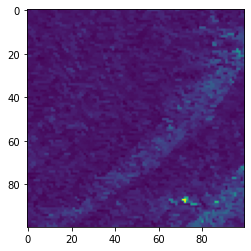

In [31]:
plt.imshow(res)

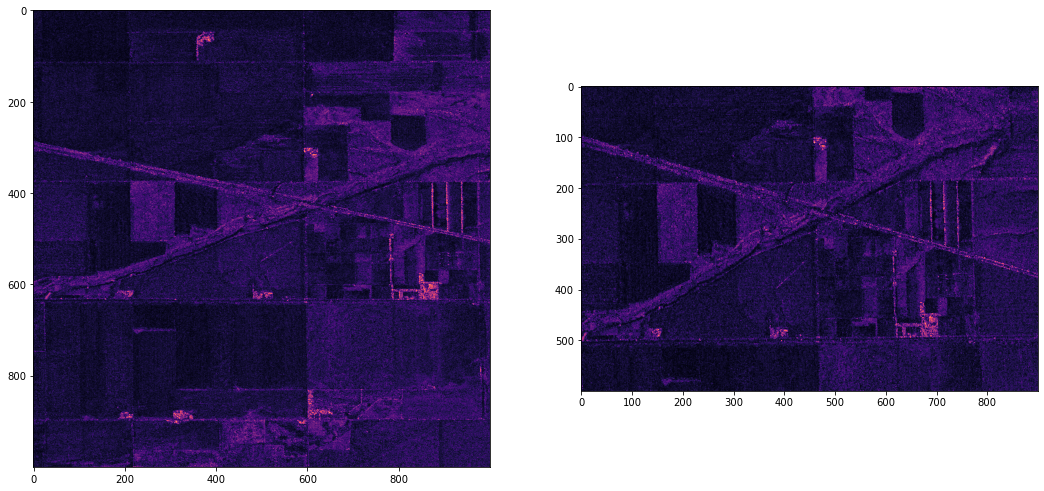

In [202]:
with rio.open('/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_alpha1.tif') as src:
    arr = src.read(1)[3900:4500,8200:9100]
f, (ax1, ax2) = plt.subplots(1,2, figsize = (18,14))
ax1.imshow(res, vmin = 0.08, vmax = 90, cmap = 'magma')
ax2.imshow(arr, vmin = 0.08, vmax = 90, cmap = 'magma')

In [59]:
import rasterio
from rasterio.crs import CRS
from rasterio.transform import Affine
type = 'grd_pwr'
# Ground projected images
# Delta latitude and longitude
dlat = desc[f'{type}.row_mult']['value']
dlon = desc[f'{type}.col_mult']['value']
# Upper left corner coordinates
lat1 = desc[f'{type}.row_addr']['value']
lon1 = desc[f'{type}.col_addr']['value']

# Lat1/lon1 are already the center so for geotiff were good to go.
t = Affine.translation(float(lon1), float(lat1))* Affine.scale(float(dlon), float(dlat))

In [109]:
import math
def calc_H(T3):
    values, _ = np.linalg.eigh(T3)
    weighted = values/np.sum(values)
    h = 0
    for i in range(3):
        h +=  weighted[i] * math.log(weighted[i], 3)
    h *= -1
    return h

In [110]:
res2 = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_C3(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3_n(c3)
            H = calc_H(t3)
            res2[row, col] = H

/var/folders/0n/swn__wf94qd3zdch1tvp087r0000gn/T/ipykernel_48501/3118558120.py:1: RuntimeWarning: invalid value encountered in multiply
  res2 = np.empty_like(sub_HHHH)*np.nan


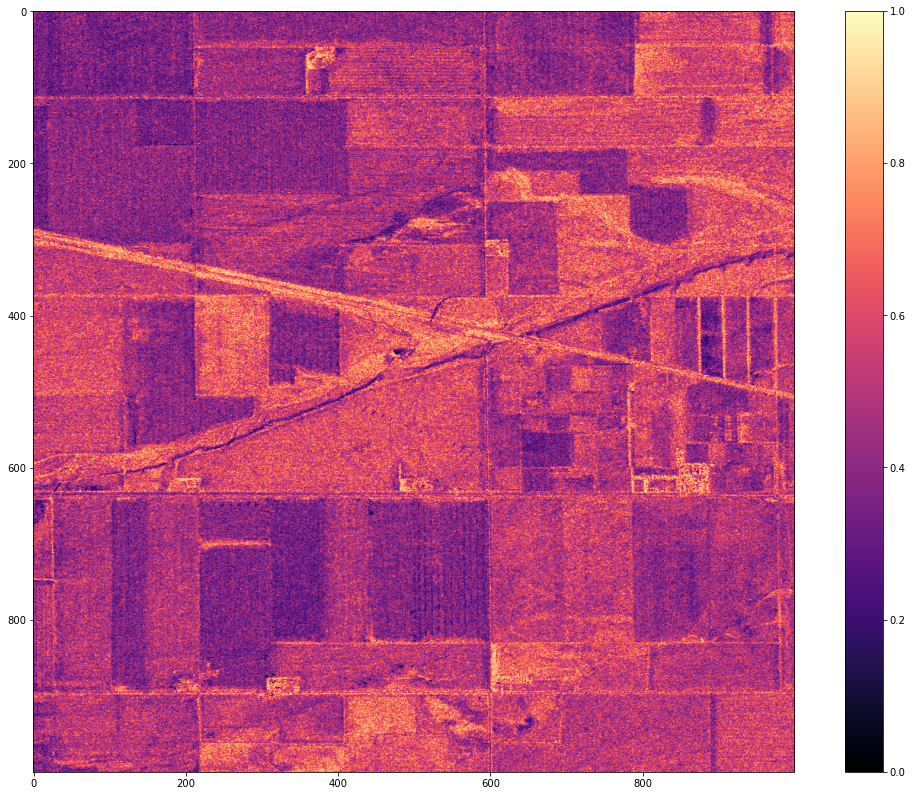

In [88]:
plt.subplots(figsize = (18,14))
plt.imshow(res, vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()

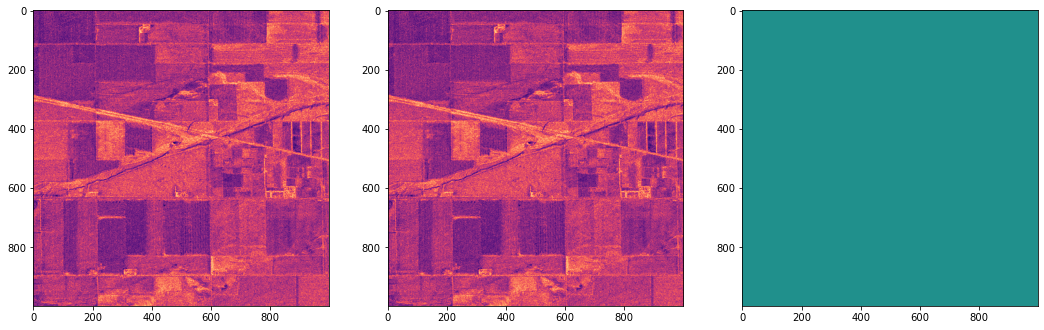

In [113]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,14))
ax1.imshow(res, vmin = 0, vmax = 1, cmap = 'magma')
# with rio.open('/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_entropy.tif') as src:
#     k_entropy = src.read(1)[3900:4500,8200:9100]
# ax2.imshow(k_entropy, vmin = 0, vmax = 1, cmap = 'magma')
ax2.imshow(res2, vmin = 0, vmax = 1, cmap = 'magma')
ax3.imshow(res2-res,vmin = -0.1, vmax = 0.1)
#plt.colorbar()

In [162]:
def calc_A(T3):
    values = np.linalg.eigvalsh(T3)
    assert values[1]> values[0]
    A = (values[1] - values[0]) / (values[1] + values[0])
    return A

In [167]:
res = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_C3(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3_n(c3)
            A = calc_A(c3)
            res[row, col] = A

/var/folders/0n/swn__wf94qd3zdch1tvp087r0000gn/T/ipykernel_48501/2613322835.py:1: RuntimeWarning: invalid value encountered in multiply
  res = np.empty_like(sub_HHHH)*np.nan


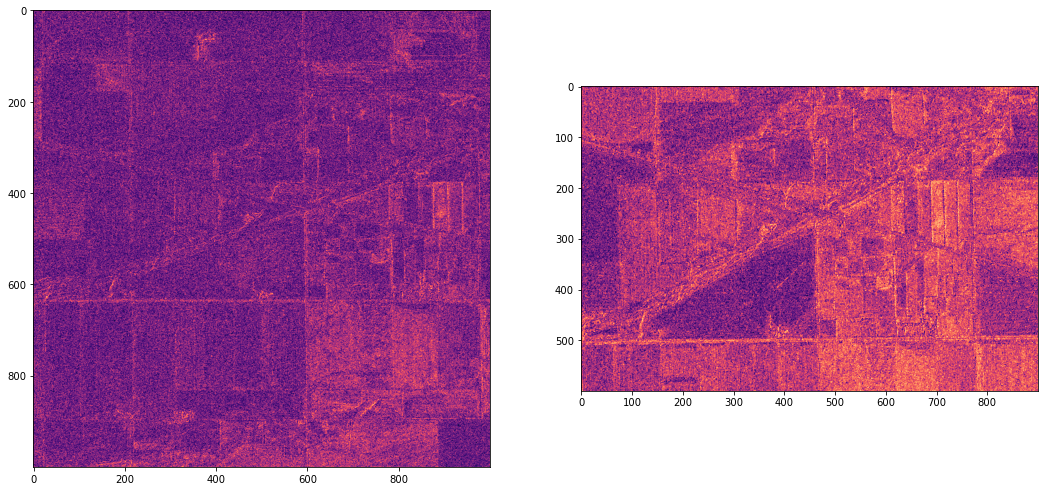

In [168]:
with rio.open('/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_anisotropy.tif') as src:
    k_entropy = src.read(1)[3900:4500,8200:9100]
f, (ax1, ax2) = plt.subplots(1,2,figsize = (18,14))
ax2.imshow(k_entropy, vmin = 0, vmax = 1, cmap = 'magma')
ax1.imshow(res, vmin = 0, vmax = 1, cmap = 'magma')